# Метод опорных векторов (SVM)

## Напоминание

[Sklearn mathematical formulation](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation)

Дана тренировачная выборка $x_i \in \mathbb{R}^p$, $y_i\in\{-1, 1\}$, $i=1,\ldots, n$. Хотим решить задачу классификации. Свели к задаче оптимизации:

\begin{equation}
    \frac{1}{2} ||w||^2 + С \sum_{i=1}^{n} \xi_i \longrightarrow \min_{w, b, \xi},\\
      \begin{split}
      \textrm {subject to }\ & y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i,\\
                             & \xi_i \geq 0.
      \end{split}
\end{equation}

Написали двойственную задачу:

\begin{equation}
    \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i\alpha_j y_i y_j \underbrace{\phi(x_i)^{T} \phi(x_j)}_{K(x_i, x_j)} - \sum_{i=1}^n \alpha_i \longrightarrow  \min_{\alpha}, \\
    \begin{split}
    \textrm {subject to }\ & \sum_{i=1}^n y_i \alpha_i = 0,\\
                           & 0 \leq \alpha_i \leq C.
    \end{split}
\end{equation}

**Важно!** Всё зависит только от $K(x_i, x_j)$, а не от обучающей выборки в первозданном виде.

В итоге решающее правило выглядит как:

\begin{equation}
y(x)= w^T\phi(x) + b = \sum_{x_i \in S} \alpha_i y_i K(x_i, x) + b \qquad \qquad (1)
\end{equation}

$S$ - множество опорных векторов.

**Важно!** Решающее правило зависит только от опорных векторов.

## Линейный SVM

In [140]:
import numpy as np
import matplotlib.pyplot as plt

### Про скорость работы

Будем пользоваться `sklearn.svm.SVC`. Она использует под капотом библиотеку libsvm, которая работает медленнее, чем библиотека liblinear (находящаяся под капотом `sklearn.svm.linearSVC`). Но последняя не позволяет получить информацию о самих опорных векторах, поэтому будем для демонстрации пользоваться первой.

Ниже код, который сравнивает скорость работы упомянутых выше библиотек:

In [141]:
import sklearn.svm as svm
import sklearn.datasets as ds
from sklearn import metrics

In [142]:
import time

def get_model_times(model, sample_sizes=(100, 300, 1000, 3000, 10000, 30000, 100000)):
    times = []
    for sample_size in sample_sizes:
        t_0 = time.time()
        X, y = ds.make_classification(n_features=2, n_classes=2, n_samples=sample_size, n_redundant=0, random_state=1)
        model = model.fit(X, y)
        times.append(time.time() - t_0)
    return sample_sizes, times

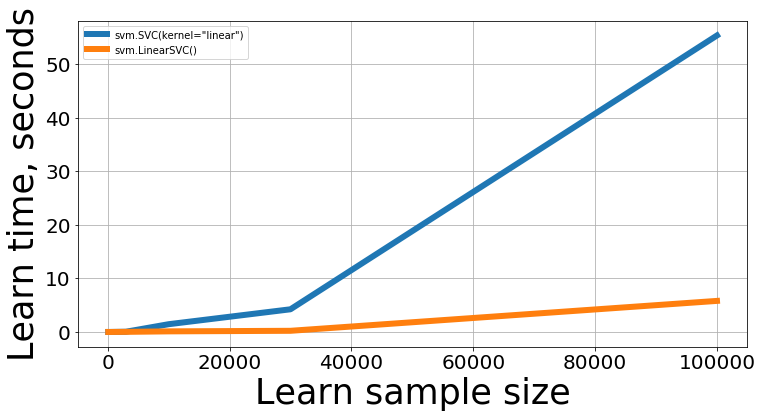

In [143]:
fig = plt.figure(figsize=(12, 6))
h1, = plt.plot(*get_model_times(svm.SVC(kernel='linear', C=1.0)), linewidth=6, label='svm.SVC(kernel="linear")')
h2, = plt.plot(*get_model_times(svm.LinearSVC(C=1.0)), linewidth=6, label='svm.LinearSVC()')

ax = plt.gca()
labels = ax.yaxis.get_majorticklabels() + ax.xaxis.get_majorticklabels()
for label in labels:
    label.set_fontsize(20)
ax.set_ylabel('Learn time, seconds', fontsize=35)
ax.set_xlabel('Learn sample size', fontsize=35)

plt.legend(handles=[h1, h2])
plt.grid('on')
plt.show()

### Про выбросы и опорные векторы

Напишем вспомогательную функцию для визуализации:

In [144]:
def plot_results(model, X, y, level=1.0, cmap=plt.cm.OrRd, use_decision_function=True, title='', plot_support_vectors=True):
    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(1, figsize=(10, 8))
    plt.clf()

    if hasattr(model, "support_vectors_") and plot_support_vectors:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=150, facecolors='none', zorder=10, edgecolor='black')
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=cmap, s=50, edgecolor='black')

    plt.axis('tight')
    
    def get_shifted_bounds(v, fraction=1.0/10):
        v_min, v_max = np.min(v), np.max(v)
        v_shift = np.abs(v_max - v_min) * fraction
        return v_min - v_shift, v_max + v_shift

    x_min, x_max = get_shifted_bounds(X[:, 0])
    y_min, y_max = get_shifted_bounds(X[:, 1])

    XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]

    if hasattr(model, "decision_function") and use_decision_function:
        Z = model.decision_function(np.c_[XX.ravel(), YY.ravel()])
    else:
        Z = model.predict(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(1, figsize=(10, 8))
    plt.pcolormesh(XX, YY, Z, cmap=cmap)
    if hasattr(model, "support_vectors_"):
        plt.contour(XX, YY, Z,
                    colors=['k', 'k', 'k'],
                    linestyles=['--', '-', '--'],
                    levels=[-level, 0, level])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)

    plt.xticks(())
    plt.yticks(())
    plt.show()

Посмотрим, как наш визуализатор работает на небольшой модельной задаче:

In [145]:
X, y = ds.make_blobs(n_samples=100, centers=2, cluster_std=1.0, center_box = (-15, 15), random_state=0)

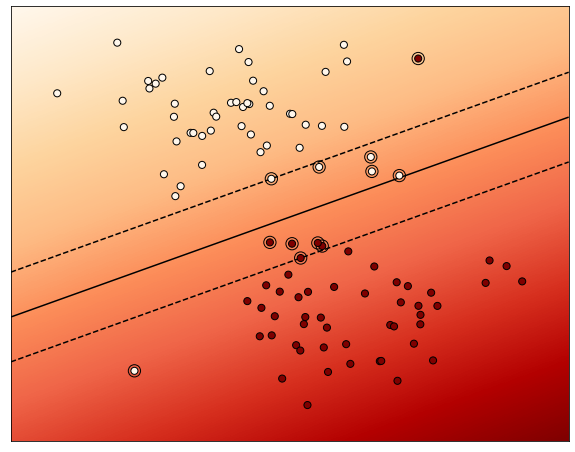

Accuracy on the training set: 0.9803921568627451


In [146]:
X, y = ds.make_blobs(n_samples=100, centers=2, cluster_std=1.0, center_box = (-15, 15), random_state=0)
X = np.concatenate((X, [[4, 8], [0, 0]]))
y = np.concatenate((y, [1, 0]))

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0)

print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

**Задание 1 (0.5 балла)**. Изменяя код только в ячейке выше, добейтесь, чтобы accuracy на тренировочной выборке было равно 1.0. Менять гиперпараметры нельзя!
Обязательно поясните, что вы изменили и почему это помогло.

Уберем выбросы из наших данных. Тогда наши классы становятся линейно разделимы, и мы можем подобрать оптимальную разделяющую поверхность.

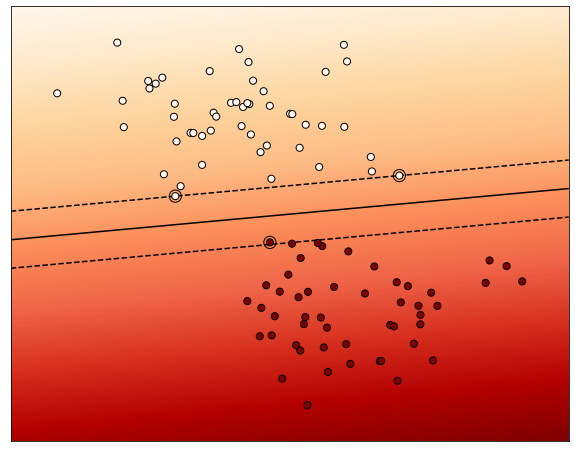

Accuracy on the training set: 1.0


In [147]:
X, y = ds.make_blobs(n_samples=100, centers=2, cluster_std=1.0, center_box = (-15, 15), random_state=0)

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0)

print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

**Задание 2 (0.25 балла)**. Как посчитать качество для задачи выше, не вызывая никаких функций, а глядя лишь на исходный код и на картинку?

Так, мы знаем количество всех объектов n_samples=102. Мы можем посчитать количество объектов, на которых была совершена ошибка. Это объекты, которые попали за разделяющую поверхность. У нас два неправильно классифицированных объекта, следовательно accuracy = 1 - 2/102 = 0.98039.

Давайте сравним, что поменяется, если мы выкинем часть объектов:

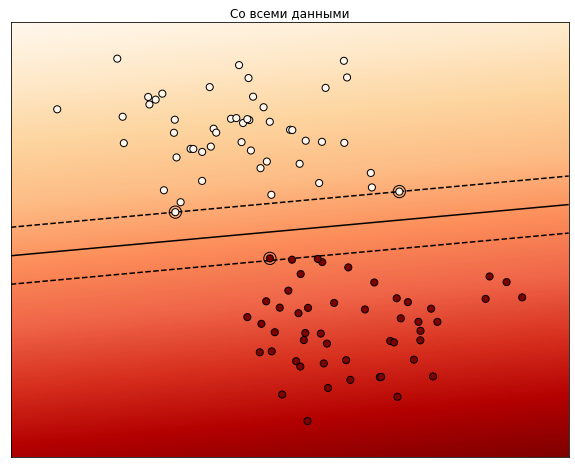

Accuracy on the training set: 1.0


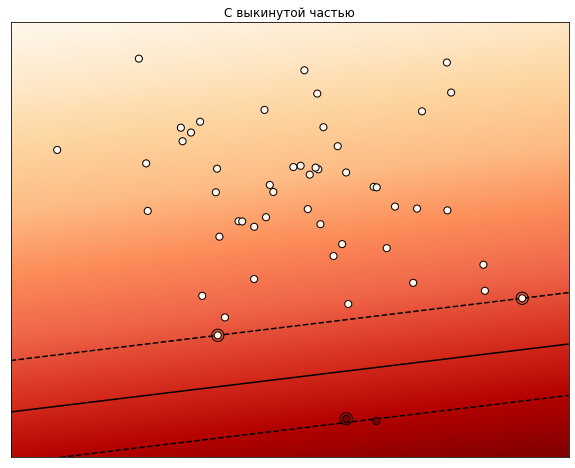

Accuracy on the training set: 1.0


In [148]:
X, y = ds.make_blobs(n_samples=100, centers=2, cluster_std=1.0, center_box = (-15, 15), random_state=0)

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0, title='Со всеми данными')
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))


# Выкидываем часть объектов, которые не являются опорными
p1 = np.array([0.57661937, 4.47488452])
p2 = np.array([3.73415974, 5.00131532])
p3 = np.array([1.90977788, 3.29011668])
det = lambda x, y: x[0]*y[1] - x[1]*y[0]
# some_up = [det(x, p2-p1) > det(p1, p2-p1)*1.01 for x in X]
some_up = [det(x, p2-p1) < det(p3, p2-p1)*0.96 for x in X]
X = X[some_up]
y = y[some_up]

model = svm.SVC(kernel='linear')
model.fit(X, y)

plot_results(model, X, y, level=1.0, title='С выкинутой частью')

print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

**Задание 3 (0.5 балла)**. Как-то разделяющие поверхности выглядят уж слишком подозрительно похоже... А может они вообще полностью идентичны? Если да, то почему?

Они идентичны, так как разделяющая поверхность строится по опорным векторам. Как мы видим из кода и графика, опорные вектора остались такими же.

### Про количество опорных векторов

Вспоминаем, как выглядит задача:

\begin{equation}
    \frac{1}{2} ||w||^2 + С \sum_{i=1}^{n} \xi_i \longrightarrow \min_{w, b, \xi},\\
      \begin{split}
      \textrm {subject to }\ & y_i (w^T \phi(x_i) + b) \geq 1 - \xi_i,\\
                             & \xi_i \geq 0.
      \end{split}
\end{equation}

И геометрическую интерпретацию:

![](https://staesthetic.files.wordpress.com/2014/02/svm.png?w=1060)

Т.к. $\frac{2}{||w||^2}$ -- это ширина разделяющей поверхности, чем она шире -- тем больше в неё попадает опорных векторов. А шире она, если $C$ поменьше. Убедимся в этом на практике:

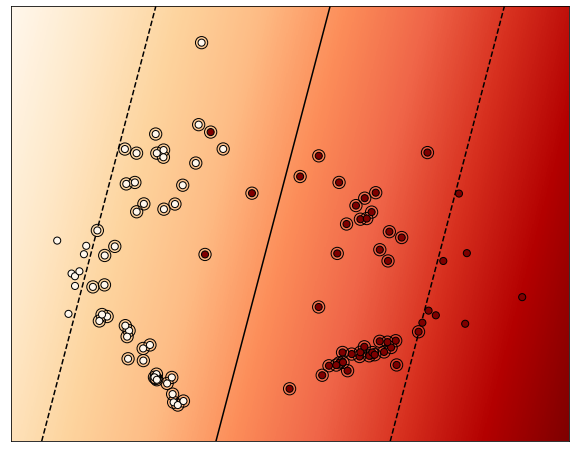

Accuracy on the training set: 0.97


In [149]:
X, y = ds.make_classification(n_features=2, n_classes=2, n_samples=100, n_redundant=0, random_state=1)

model = svm.SVC(kernel='linear', C=0.01)
model.fit(X, y)
plot_results(model, X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

### Про линейно-неразделимую выборку

Окей, с линейно-разделимой выборкой понятно. А что, если ситуация жизненная, т.е. выборка не является линейно-разделимой?

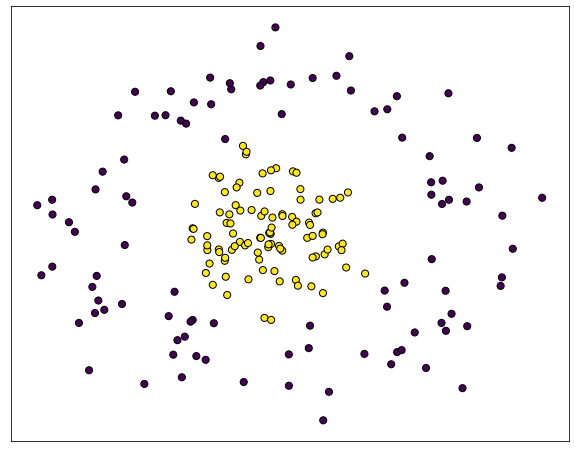

In [150]:
X, y = ds.make_circles(noise=0.2, factor=0.2, random_state=1, n_samples=200)

plt.figure(1, figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, s=50, edgecolor='black')
plt.xticks(())
plt.yticks(())
plt.show()

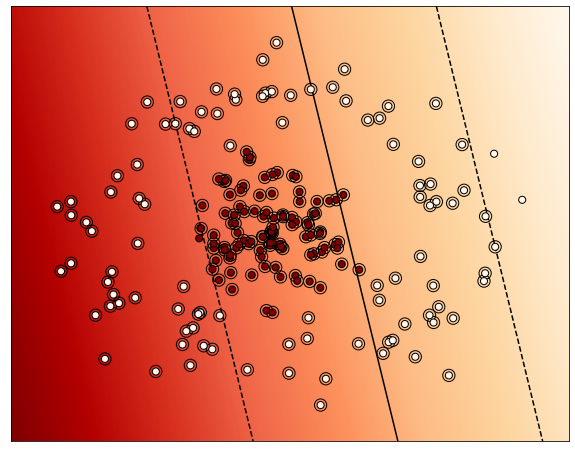

Accuracy on the training set: 0.68


In [151]:
model = svm.SVC(kernel='linear', C=1)
model.fit(X, y)
plot_results(model, X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

Вы можете возразить: но мы же даже не подобрали гиперпараметры! Но, кажется, понятно, что линейным алгоритмом нормально решить задачу не выйдет :)

Упс... Задача вроде простая, но не для нашего SVM'а... Тем не менее, есть преобразование, которое сделает так, чтобы задача оказалась ему по плечу:
$$
(x, y) \to (x, y, x^2 + y^2)
$$

**Задание 4. (0.75 балла)** Спасите линейный SVM! Переведите объекты в другое признаковое пространство, используйте на новой выборке линейный SVM и визуализируйте то, что у вас получилось, в двухмерном пространстве. Кажется, для визуализации придётся скопировать и подхачить исходную функцию.

In [152]:
def plot_circle(model, X, y, level=1.0, cmap=plt.cm.OrRd, use_decision_function=True, title=''):
    plt.figure(1, figsize=(10, 8))
    plt.clf()

    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=cmap, s=50, edgecolor='black')
    plt.axis('tight')


    def get_shifted_bounds(v, fraction=1.0 / 10):
        v_min, v_max = np.min(v), np.max(v)
        v_shift = np.abs(v_max - v_min) * fraction
        return v_min - v_shift, v_max + v_shift


    x_min, x_max = get_shifted_bounds(X[:, 0])
    y_min, y_max = get_shifted_bounds(X[:, 1])

    XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]
    R = XX**2 + YY**2
    R = R.ravel()[:, np.newaxis]
    
    Z = model.decision_function(R)

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(1, figsize=(10, 8))
    plt.pcolormesh(XX, YY, Z, cmap=cmap)
    if hasattr(model, "support_vectors_"):
        plt.contour(XX, YY, Z,
                    colors=['k', 'k', 'k'],
                    linestyles=['--', '-', '--'],
                    levels=[-level, 0, level])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)

    plt.xticks(())
    plt.yticks(())
    plt.show()

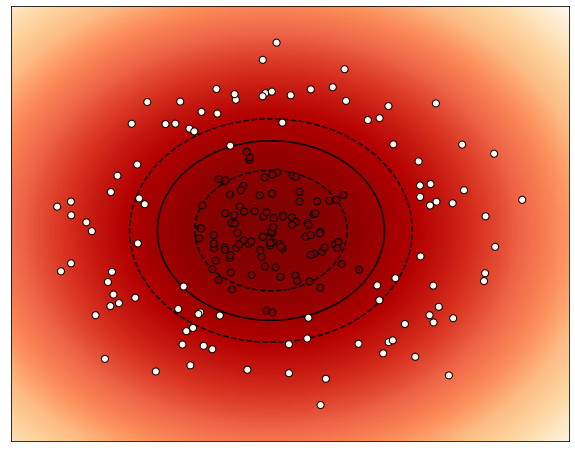

Accuracy on the training set: 0.995


In [153]:
r = X[:, 0]**2 + X[:, 1]**2
r = r[:, np.newaxis]

model = svm.SVC(kernel='linear', C=1)
model.fit(r, y)
plot_circle(model, X, y)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(r)))

## Ядра - чистый изумруд!

Но для каждого случая подбирать признаковое пространство - это очень сложно. Да и вообще, если вспомнить про двойственную задачу, то становится ясно, что нам нужно даже не сами признаки знать в новом пространстве, а лишь уметь вычислять скалярное произведение.

Воспользуемся ядровым переходом с простым полиномиальным ядром. Напоминание:

$$
K(x,y) = (x^\mathsf{T} y + c)^{d}
$$

Попробуем применить параметры по-умолчанию:

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


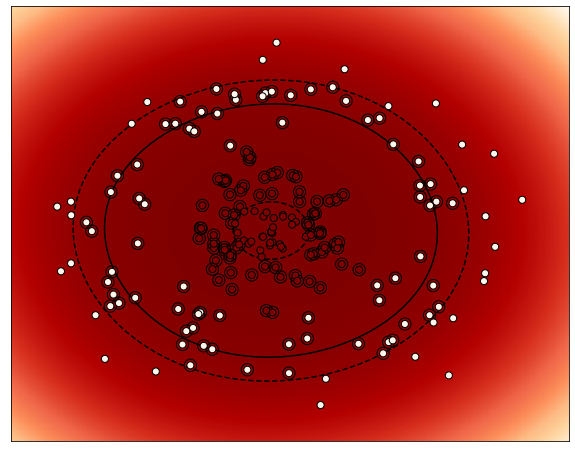

Accuracy on the training set: 0.855


In [154]:
model = svm.SVC(kernel='poly', C=1, degree=4)
model.fit(X, y)
plot_results(model, X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

Опа, такой SVM нам подходит!

![](https://i.ibb.co/4Mc322f/kernel-trick.png)

А теперь задачка посложнее:

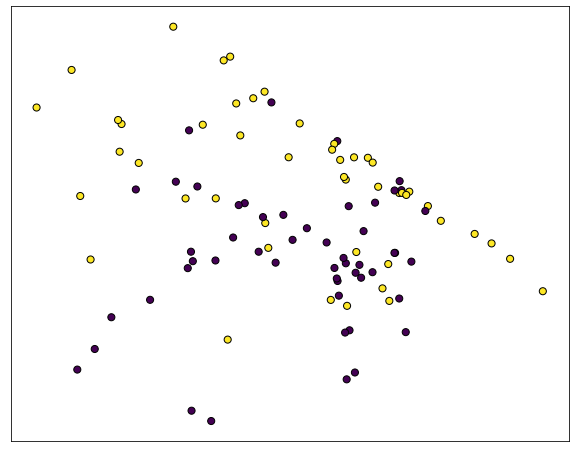

In [155]:
X, y = ds.make_classification(n_features=2, n_classes=2, n_samples=100, n_redundant=0, random_state=3, flip_y=0.3)

plt.figure(1, figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, s=50, edgecolor='black')
plt.xticks(())
plt.yticks(())
plt.show()

Посмотрим, как меняется картинка классификации в зависимости от параметров $C$ и $\gamma$:

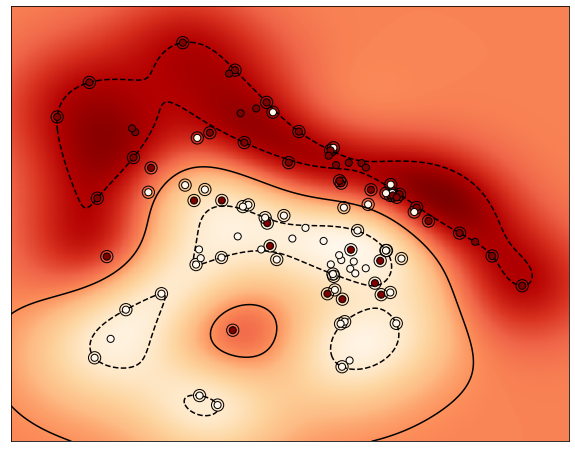

Accuracy on the training set: 0.81


In [156]:
model = svm.SVC(kernel='rbf', C=1, gamma=1.0)
model.fit(X, y)
plot_results(model, X, y, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y, model.predict(X)))

## Про переобучение

Рассмотрим ещё одну небольшую модельную задачу ([данные](https://yadi.sk/d/Yd1Xipl2WOFdHQ)):

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


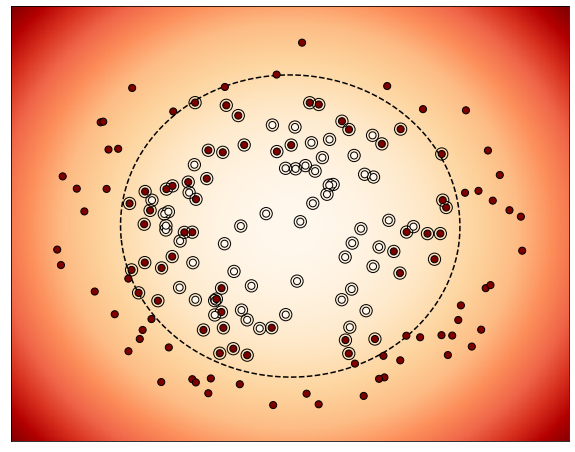

Accuracy on the training set: 0.6829268292682927


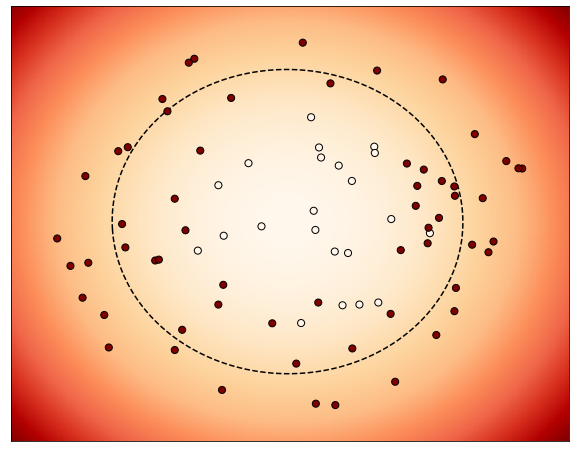

Accuracy on the testing set: 0.7317073170731707


In [157]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('data_svm.csv')
X = df[['X1', 'X2']].values
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)
model = svm.SVC(kernel='poly', degree=2, C=0.1)
model.fit(X_train, y_train)
plot_results(model, X_train, y_train, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y_train, model.predict(X_train)))
plot_results(model, X_test, y_test, level=1.0, plot_support_vectors=False)
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model.predict(X_test)))

Как вы можете заметить, значения точности не сильно отличаются для обучающей и тестовой выборки. Но так будет не обязательно... И вам предстоит это доказать!

**Задание 5 (1 балл).** Добейтесь ряда разных эффектов, перебирая параметры классификатора SVM:
* как можно бОльшего недообучения: когда качество и на обучающей, и на тестовой выборке очень плохое
* как можно бОльшего переобучения: когда качество на обучающей выборке очень хорошее, а на тестовой не очень хорошее
* оптимального обучения: когда и на обучающей, и, главное, на тестовой выборке, всё окей

Подберите параметры, посчитайте соответствующие качества и визуализируйте получившиеся модели. Конкретных требований к числам нет, постарайтесь сделать всё, что в ваших силах, для минимизации и максимизации их!

Для недообучения возьмем в качестве ядра линейное. По графику видно, что наши объекты не разделимы линейно, что должно привести к ожидаемо плохому результату на обеих выборках.

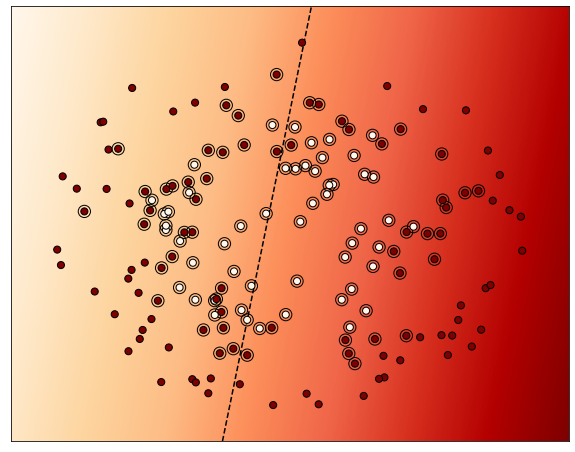

Accuracy on the training set: 0.6829268292682927


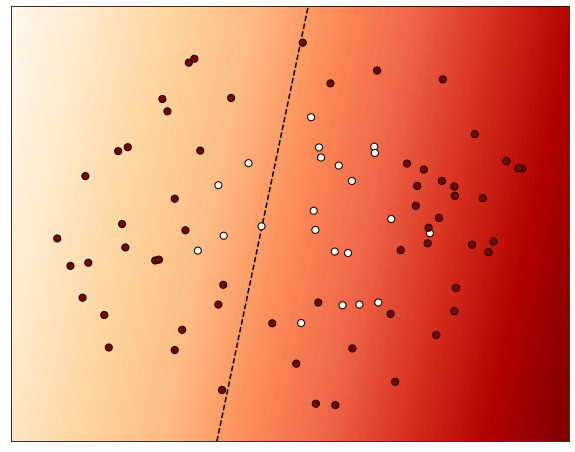

Accuracy on the testing set: 0.7317073170731707


In [158]:
model_under = svm.SVC(kernel='linear')
model_under.fit(X_train, y_train)

plot_results(model_under, X_train, y_train, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y_train, model_under.predict(X_train)))
plot_results(model_under, X_test, y_test, level=1.0, plot_support_vectors=False)
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model_under.predict(X_test)))

Для переобучения нам требуется выбрать нелинейное ядро, при котором построенные поверхности будут нелинейны и будут хорошо подстраиваться под выборку. Возьмем ядро 'rbf' и поизменяем параметр 'gamma'. (Чем больше гамма -> тем меньше значение ядра).

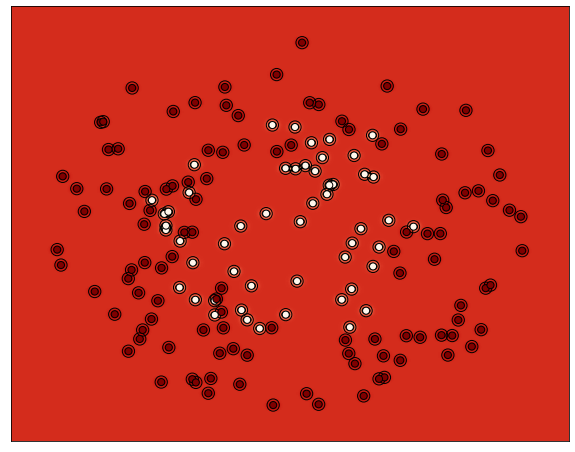

Accuracy on the training set: 0.9939024390243902


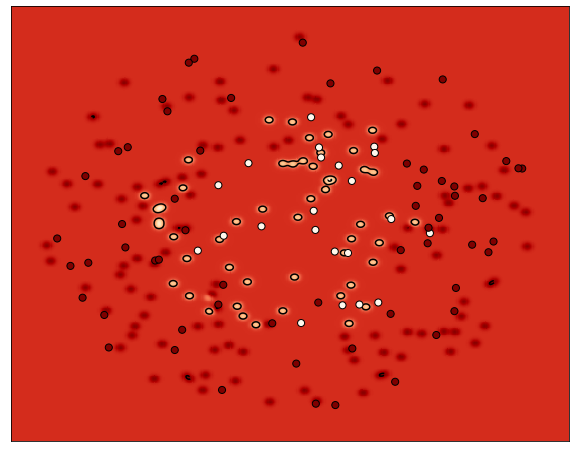

Accuracy on the testing set: 0.7439024390243902


In [159]:
model_under = svm.SVC(kernel='rbf', C=1, gamma=10000)
model_under.fit(X_train, y_train)

plot_results(model_under, X_train, y_train, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y_train, model_under.predict(X_train)))
plot_results(model_under, X_test, y_test, level=1.0, plot_support_vectors=False)
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model_under.predict(X_test)))

Для оптимального обучения подберем параметры с помощью GridCV.

In [160]:
from sklearn.model_selection import GridSearchCV, KFold

In [161]:
param_grid = {
    'kernel': ['rbf',  'sigmoid', 'poly'],
    'degree': [2, 3, 4, 5],
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10]
}

In [162]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
est = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy', n_jobs=-1, verbose=1)
est.fit(X_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    3.8s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4, 5],
                         'gamma': ['scale', 0.1, 1, 10],
                         'kernel': ['rbf', 'sigmoid', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [163]:
print(f'Best parameters: {est.best_params_}')

Best parameters: {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}


In [164]:
clf = est.best_estimator_

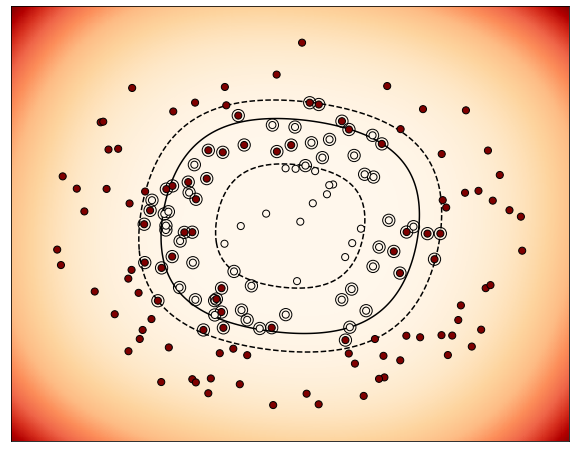

Accuracy on the training set: 0.8597560975609756


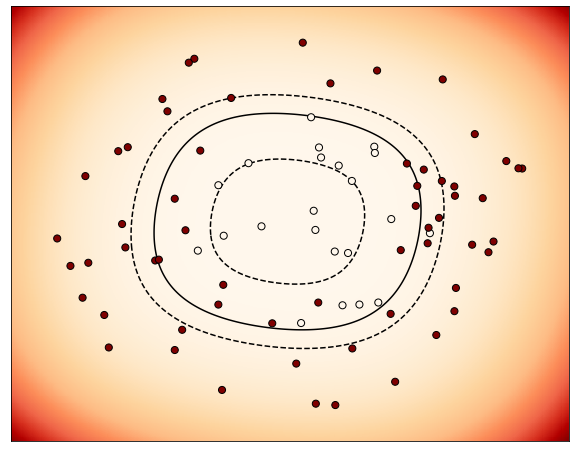

Accuracy on the testing set: 0.8414634146341463


In [165]:
plot_results(clf, X_train, y_train, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y_train, clf.predict(X_train)))
plot_results(clf, X_test, y_test, level=1.0, plot_support_vectors=False)
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, clf.predict(X_test)))

Методом научного тыка попала еще такая модель :)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


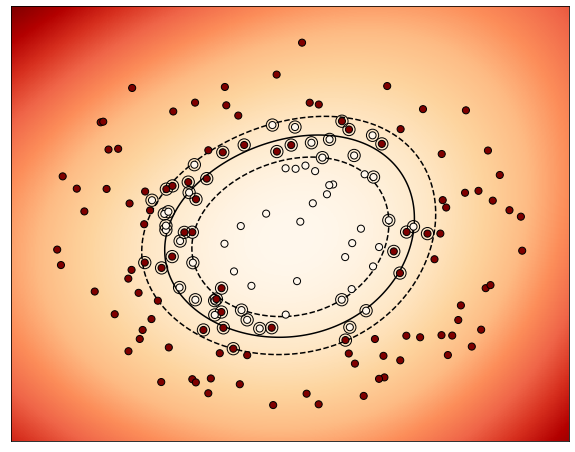

Accuracy on the training set: 0.8536585365853658


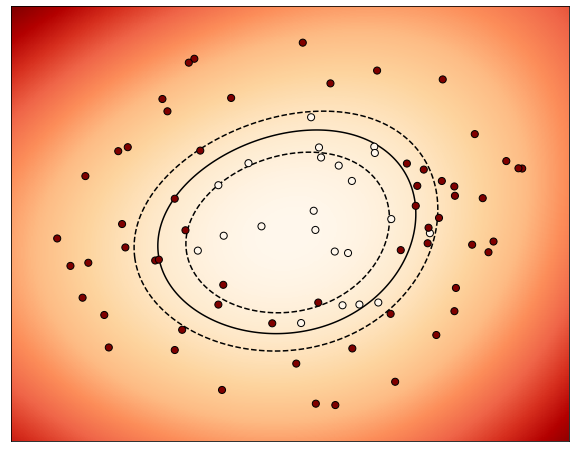

Accuracy on the testing set: 0.8780487804878049


In [168]:
model_under = svm.SVC(kernel='rbf', C=1000)
model_under.fit(X_train, y_train)

plot_results(model_under, X_train, y_train, level=1.0)
print('Accuracy on the training set:', metrics.accuracy_score(y_train, model_under.predict(X_train)))
plot_results(model_under, X_test, y_test, level=1.0, plot_support_vectors=False)
print('Accuracy on the testing set:', metrics.accuracy_score(y_test, model_under.predict(X_test)))